In [2]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
!pip install torchinfo
from torchinfo import summary
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_transform = transforms.Compose([
    # 이미지를 256x256으로 리사이즈 
    transforms.Resize(256), 
    
    # 224x224 크기로 무작위로 잘라냄 (모델 입력 규격에 맞춤)
    transforms.RandomResizedCrop(224), 
    
    # 이미지를 0~1 사이의 Tensor로 변환하고 타입을 float32로 변경
    transforms.ToTensor(), 
    
    # ImageNet 데이터셋의 평균과 표준편차로 정규화 (전처리 표준)
    # 이 과정이 "Normalized Initialization"과 함께 학습 안정성을 돕습니다.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. 테스트/검증 데이터용 Transform: 증강 없이 원본의 특징만 반영하도록 구성합니다.
test_transform = transforms.Compose([
    # 테스트 시에도 입력 크기는 동일하게 224x224로 맞춤
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [47]:
# 훈련 데이터셋 로드
train_dataset = torchvision.datasets.OxfordIIITPet(
    root='./data',
    split='trainval',      # 훈련 및 검증용 데이터 분할
    target_types='binary-category', 
    download=True,
    transform=train_transform # 위에서 정의한 훈련용 변형 적용
)

# 테스트 데이터셋 로드
test_dataset = torchvision.datasets.OxfordIIITPet(
    root='./data',
    split='test',
    target_types='binary-category',
    download=True,
    transform=test_transform # 테스트용 변형 적용
)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

ValueError: Unknown value 'species' for argument target_types. Valid values are {'category', 'binary-category', 'segmentation'}.

In [58]:
# 데이터셋을 로드하고 기본 정보를 확인해 보세요.
image, label = train_dataset[113]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Number of classes: {len(train_dataset.classes)}")

Image shape: torch.Size([3, 224, 224])
Label: 1
Number of classes: 37


In [17]:
from torch import nn


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [18]:
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion*planes,
            kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [39]:
import torch


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super().__init__()

        self.inplanes = 64
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1)
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2)
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(num_blocks - 1):
            layers.append(block(self.inplanes, planes, 1))

        return nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.stem(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out
    
    

In [40]:
from torchvision import models
from torchinfo import summary


resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], 2)
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 2)
resnet50 = ResNet(BottleneckBlock, [3, 4, 6, 3], 2)
resnet101 = ResNet(BottleneckBlock, [3, 4, 23, 3], 2)
resnet152 = ResNet(BottleneckBlock, [3, 8, 36, 3], 2)
torch_model = models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")

resnet34_info = summary(resnet34, (1, 3, 224, 224), verbose=0)
resnet50_info = summary(resnet50, (1, 3, 224, 224), verbose=0)
torch_model_info = summary(torch_model, (1, 3, 224, 224), verbose=0)

print(resnet34_info.total_params)
print(torch_model_info.total_params)

21285698
21797672


In [41]:
resnet34_info

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-5                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│

In [42]:
resnet50_info

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─BottleneckBlock: 2-5              [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│ 

### ResNet34 실험

In [64]:
model = ResNet(BasicBlock, [3, 4, 6, 3], num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실 함수 및 옵티마이저 (논문 기반 설정)
criterion = nn.CrossEntropyLoss()
# lr=0.1에서 시작해 에러가 정체되면 줄이는 전략 (여기선 0.001로 미세 조정 시작)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

ResNet_34_train_losses = []
ResNet_34_val_accuracy = []

# 학습 루프
EPOCHS = 15
for epoch in range(EPOCHS):
    model.train() # 학습 모드 활성화 (BN 동작)
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # 기울기 초기화
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels)
        loss.backward() # Backward pass
        optimizer.step() # 가중치 업데이트

        running_loss += loss.item()

    # 에폭별 검증 (Validation)
    model.eval() # 평가 모드 활성화
    correct = 0
    total = 0
    with torch.no_grad(): # 메모리 절약
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {running_loss/len(trainloader):.4f} Acc: {100 * correct / total:.2f}%")
    
    train_loss = running_loss / len(trainloader)
    ResNet_34_train_losses.append(train_loss)
    
    val_acc = 100 * correct / total
    ResNet_34_val_accuracy.append(val_acc)

print("Finished Training")

Epoch [1/10] Loss: 0.6479 Acc: 55.85%
Epoch [2/10] Loss: 0.6473 Acc: 67.51%
Epoch [3/10] Loss: 0.6266 Acc: 68.38%
Epoch [4/10] Loss: 0.6120 Acc: 69.58%
Epoch [5/10] Loss: 0.6199 Acc: 66.94%
Epoch [6/10] Loss: 0.5978 Acc: 68.82%
Epoch [7/10] Loss: 0.5897 Acc: 69.09%
Epoch [8/10] Loss: 0.5916 Acc: 68.08%
Epoch [9/10] Loss: 0.5767 Acc: 69.09%
Epoch [10/10] Loss: 0.5776 Acc: 71.63%
Finished Training


### ResNet50 실험

In [65]:
model = ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. 손실 함수 및 옵티마이저 (논문 기반 설정)
criterion = nn.CrossEntropyLoss()
# lr=0.1에서 시작해 에러가 정체되면 줄이는 전략 (여기선 0.001로 미세 조정 시작)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

ResNet_50_train_losses = []
ResNet_50_val_accuracy = []

# 5. 학습 루프
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train() # 학습 모드 활성화 (BN 동작)
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # 기울기 초기화
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels)
        loss.backward() # Backward pass
        optimizer.step() # 가중치 업데이트

        running_loss += loss.item()

    # 에폭별 검증 (Validation)
    model.eval() # 평가 모드 활성화
    correct = 0
    total = 0
    with torch.no_grad(): # 메모리 절약
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {running_loss/len(trainloader):.4f} Acc: {100 * correct / total:.2f}%")
    
    train_loss = running_loss / len(trainloader)
    ResNet_50_train_losses.append(train_loss)
    
    val_acc = 100 * correct / total
    ResNet_50_val_accuracy.append(val_acc)

print("Finished Training")

Epoch [1/10] Loss: 0.8000 Acc: 67.92%
Epoch [2/10] Loss: 0.7124 Acc: 65.99%
Epoch [3/10] Loss: 0.6808 Acc: 67.92%
Epoch [4/10] Loss: 0.6539 Acc: 67.59%
Epoch [5/10] Loss: 0.6521 Acc: 68.57%
Epoch [6/10] Loss: 0.6201 Acc: 68.22%
Epoch [7/10] Loss: 0.6168 Acc: 70.86%
Epoch [8/10] Loss: 0.6502 Acc: 69.91%
Epoch [9/10] Loss: 0.6089 Acc: 69.07%
Epoch [10/10] Loss: 0.6049 Acc: 69.07%
Finished Training


### Plain 함수 생성

In [62]:
# Plain 34를 위한 기본 블록 (Shortcut 없음)
class PlainBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PlainBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.LogitsNormalization() if False else nn.BatchNorm2d(planes) # Intermediate Normalization
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        # (a) Original 방식: 연산 후 BN/ReLU 적용
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.relu(out) # Shortcut 더하기 없이 바로 ReLU
        return out

# Plain 50을 위한 보틀넥 블록 (Shortcut 없음)
class PlainBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PlainBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.relu(out) # Shortcut 연산 제거
        return out

In [63]:
class PlainNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(PlainNet, self).__init__()
        self.in_planes = 64

        # 초기 7x7 Conv 레이어
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet과 동일한 스테이지 구성
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

### PlainNet 34 실험

In [66]:
model = PlainNet(PlainBasicBlock, [3, 4, 6, 3])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. 손실 함수 및 옵티마이저 (논문 기반 설정)
criterion = nn.CrossEntropyLoss()
# lr=0.1에서 시작해 에러가 정체되면 줄이는 전략 (여기선 0.001로 미세 조정 시작)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

PlainNet_34_train_losses = []
PlainNet_34_val_accuracy = []

# 5. 학습 루프
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train() # 학습 모드 활성화 (BN 동작)
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # 기울기 초기화
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels)
        loss.backward() # Backward pass
        optimizer.step() # 가중치 업데이트

        running_loss += loss.item()

    # 에폭별 검증 (Validation)
    model.eval() # 평가 모드 활성화
    correct = 0
    total = 0
    with torch.no_grad(): # 메모리 절약
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {running_loss/len(trainloader):.4f} Acc: {100 * correct / total:.2f}%")
    
    train_loss = running_loss / len(trainloader)
    PlainNet_34_train_losses.append(train_loss)
    
    val_acc = 100 * correct / total
    PlainNet_34_val_accuracy.append(val_acc)

print("Finished Training")

Epoch [1/10] Loss: 0.6493 Acc: 66.39%
Epoch [2/10] Loss: 0.6427 Acc: 67.76%
Epoch [3/10] Loss: 0.6282 Acc: 67.76%
Epoch [4/10] Loss: 0.6317 Acc: 66.34%
Epoch [5/10] Loss: 0.6271 Acc: 67.76%
Epoch [6/10] Loss: 0.6215 Acc: 67.78%
Epoch [7/10] Loss: 0.6140 Acc: 68.49%
Epoch [8/10] Loss: 0.6183 Acc: 67.76%
Epoch [9/10] Loss: 0.6132 Acc: 67.76%
Epoch [10/10] Loss: 0.6130 Acc: 68.11%
Finished Training


### PlainNet 50 실험

In [67]:
model = PlainNet(PlainBottleneck, [3, 4, 6, 3])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. 손실 함수 및 옵티마이저 (논문 기반 설정)
criterion = nn.CrossEntropyLoss()
# lr=0.1에서 시작해 에러가 정체되면 줄이는 전략 (여기선 0.001로 미세 조정 시작)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

PlainNet_50_train_losses = []
PlainNet_50_val_accuracy = []

# 5. 학습 루프
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train() # 학습 모드 활성화 (BN 동작)
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # 기울기 초기화
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels)
        loss.backward() # Backward pass
        optimizer.step() # 가중치 업데이트

        running_loss += loss.item()

    # 에폭별 검증 (Validation)
    model.eval() # 평가 모드 활성화
    correct = 0
    total = 0
    with torch.no_grad(): # 메모리 절약
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {running_loss/len(trainloader):.4f} Acc: {100 * correct / total:.2f}%")
    
    train_loss = running_loss / len(trainloader)
    PlainNet_50_train_losses.append(train_loss)
    
    val_acc = 100 * correct / total
    PlainNet_50_val_accuracy.append(val_acc)

print("Finished Training")

Epoch [1/10] Loss: 0.6508 Acc: 67.89%
Epoch [2/10] Loss: 0.6405 Acc: 67.81%
Epoch [3/10] Loss: 0.6485 Acc: 67.76%
Epoch [4/10] Loss: 0.6511 Acc: 67.21%
Epoch [5/10] Loss: 0.6377 Acc: 67.76%
Epoch [6/10] Loss: 0.6339 Acc: 66.67%
Epoch [7/10] Loss: 0.6372 Acc: 67.76%
Epoch [8/10] Loss: 0.6316 Acc: 67.76%
Epoch [9/10] Loss: 0.6290 Acc: 68.74%
Epoch [10/10] Loss: 0.6229 Acc: 67.68%
Finished Training


### ResNet 34 vs PlainNet 34 비교

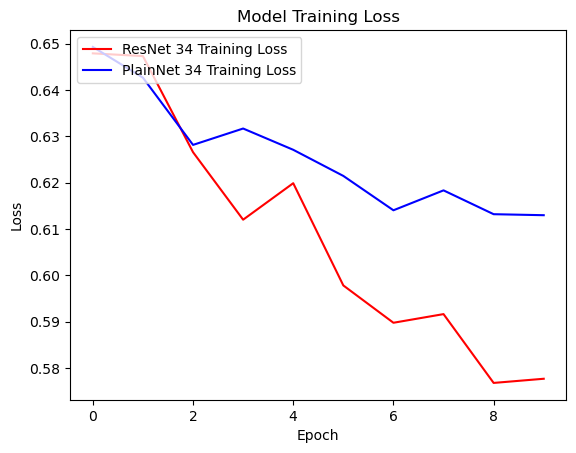

In [68]:
import matplotlib.pyplot as plt

plt.plot(ResNet_34_train_losses, 'r', label="ResNet 34 Training Loss")
plt.plot(PlainNet_34_train_losses, 'b', label="PlainNet 34 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

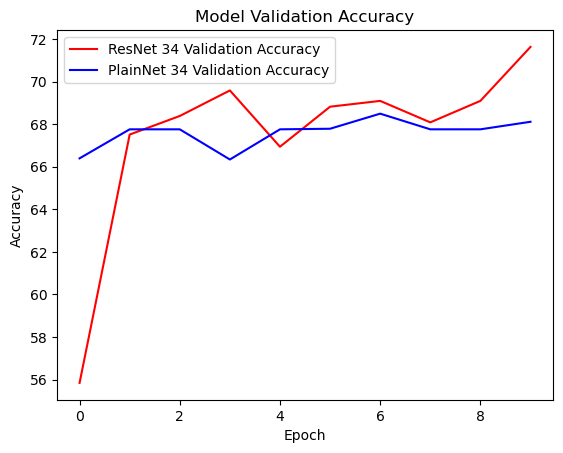

In [69]:
plt.plot(ResNet_34_val_accuracy, 'r', label="ResNet 34 Validation Accuracy")
plt.plot(PlainNet_34_val_accuracy, 'b', label="PlainNet 34 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### ResNet 50 vs PlainNet 50 비교

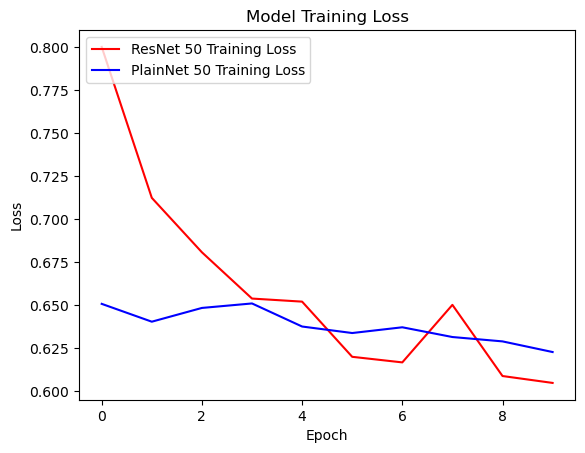

In [70]:
import matplotlib.pyplot as plt

plt.plot(ResNet_50_train_losses, 'r', label="ResNet 50 Training Loss")
plt.plot(PlainNet_50_train_losses, 'b', label="PlainNet 50 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

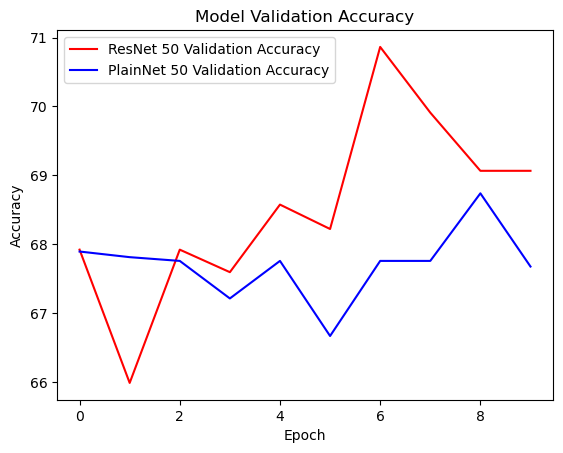

In [71]:
plt.plot(ResNet_50_val_accuracy, 'r', label="ResNet 50 Validation Accuracy")
plt.plot(PlainNet_50_val_accuracy, 'b', label="PlainNet 50 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()